<a href="https://colab.research.google.com/github/itberrios/algotrading/blob/main/stock_data_explorer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Stock Data Explorer**

In this notebook we will aquire stock data and explore it.

## Install necessary Libraries

In [ ]:
!pip install pandas_ta

In [ ]:
!pip install alpha_vantage

## Base Library Import

In [200]:
import os
import numpy as np
import pandas as pd
import pandas_ta as ta
import alpha_vantage
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (20, 10)
%matplotlib inline

In [201]:
API_KEY = 'K1GZTUTQ65SVGLNU'

## Get Daily Stock Data from Home Depot

In [9]:
import requests

base_url = 'https://www.alphavantage.co/query?'
function = 'TIME_SERIES_DAILY'
outputsize = 'full' # full returns all data, compact returns a the most recent 100
symbol = 'HD'

response = requests.get(f'{base_url}function={function}&symbol={symbol}&outputsize={outputsize}&apikey={API_KEY}')
response_dict = response.json()
_, header = response.json()

place data in DataFrame

In [21]:
df = pd.DataFrame.from_dict(response_dict[header], orient='index')

df_cols = [i.split(' ')[1] for i in df.columns]
df.columns = df_cols

# convert index to DateTime
df.index = pd.to_datetime(df.index)

# covnert to float64
df = df.astype(np.float64)

print(df)

              open    high     low   close     volume
2022-09-16  269.05  276.56  268.90  275.97  9535105.0
2022-09-15  277.89  278.01  270.54  271.54  3896084.0
2022-09-14  279.40  279.54  273.17  276.34  4194435.0
2022-09-13  292.01  294.08  277.32  277.93  4797246.0
2022-09-12  300.80  302.83  296.35  297.54  3632935.0
...            ...     ...     ...     ...        ...
1999-11-05   77.00   78.75   77.00   78.00  3704400.0
1999-11-04   76.31   76.94   75.69   76.00  2250667.0
1999-11-03   76.75   76.94   74.88   75.25  3053000.0
1999-11-02   77.00   77.50   75.75   77.00  3789400.0
1999-11-01   75.63   77.06   75.56   76.25  3602800.0

[5757 rows x 5 columns]


Save to a .csv for later usage

In [27]:
df.to_csv('hd.csv')

## Checkpoint

In [203]:
df = pd.read_csv('hd.csv', index_col=0)
df

,open,high,low,close,volume
2022-09-16,269.05,276.56,268.90,275.97,9535105.0
2022-09-15,277.89,278.01,270.54,271.54,3896084.0
2022-09-14,279.40,279.54,273.17,276.34,4194435.0
2022-09-13,292.01,294.08,277.32,277.93,4797246.0
2022-09-12,300.80,302.83,296.35,297.54,3632935.0
...,...,...,...,...,...
1999-11-05,77.00,78.75,77.00,78.00,3704400.0
1999-11-04,76.31,76.94,75.69,76.00,2250667.0
1999-11-03,76.75,76.94,74.88,75.25,3053000.0
1999-11-02,77.00,77.50,75.75,77.00,3789400.0


We can plot a bar chart if we want to, see [this](https://www.statology.org/matplotlib-python-candlestick-chart/)

Now we can split into train, validation, and test sets. We will use a roughly 60-20-20 split for this

In [204]:
df.shape

(5757, 5)

In [205]:
train_df = df.iloc[2302:, :]
valid_df = df.iloc[1151:2302, :]
test_df = df.iloc[:1151, :]

Now we can close inspect and analye the training data. The first thing we will do is plot Simple Moving Averages (SMA) which that the unweighted mean of the previous M points

In [266]:
# compute simple moving averages
close_sma_10 = train_df['close'].rolling(10, min_periods=1).mean()# .name('close SMA 10')
close_sma_30 = train_df['close'].rolling(30, min_periods=1).mean()

# rename series
close_sma_10.name = 'close SMA 10'
close_sma_30.name = 'close SMA 30'

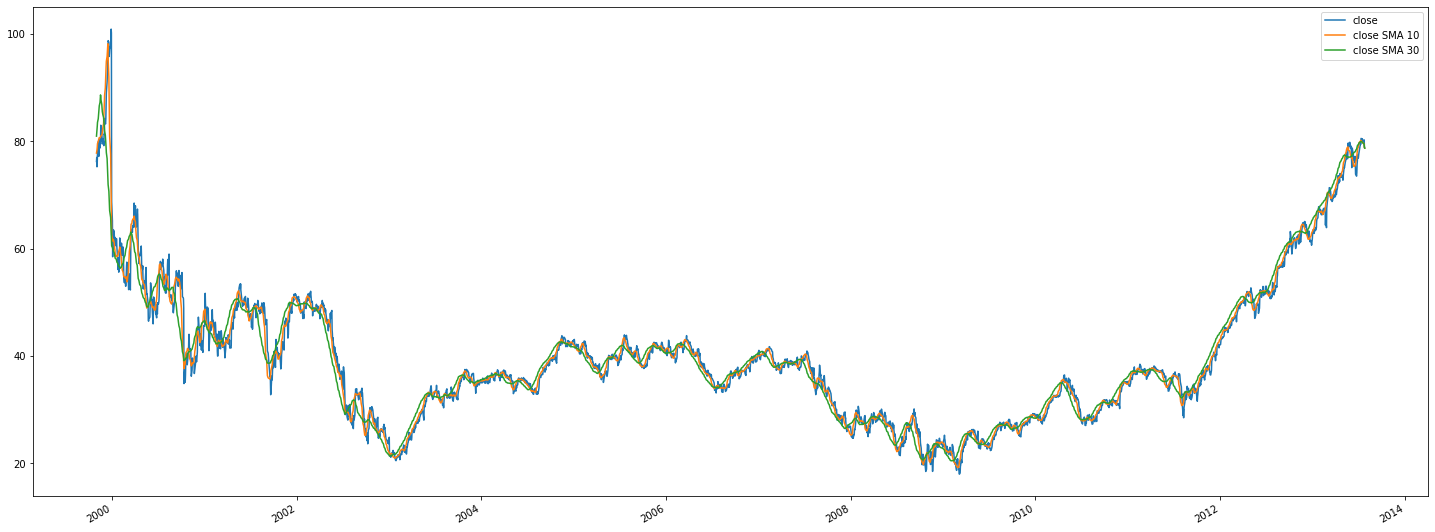

In [123]:
train_df['close'].plot(figsize=(25, 10))
close_sma_10.plot(figsize=(25, 10))
close_sma_30.plot(figsize=(25, 10))
plt.legend();

Now we will compute the Exponential Moving Average (EMA), the EMA gives more weight to more recent points and is useful to identify trends and filter out noise. Thee EMA formula has a smoothing factor $\alpha \in [0, 1]$ which allows for more or less smoothing

In [267]:
# compute Exponentially Weighted Mean
close_ema_01 = train_df['close'].ewm(alpha=0.1).mean()
close_ema_03 = train_df['close'].ewm(alpha=0.3).mean()

# rename series
close_ema_01.name = 'close EMA 0.1'
close_ema_03.name = 'close EMA 0.3'

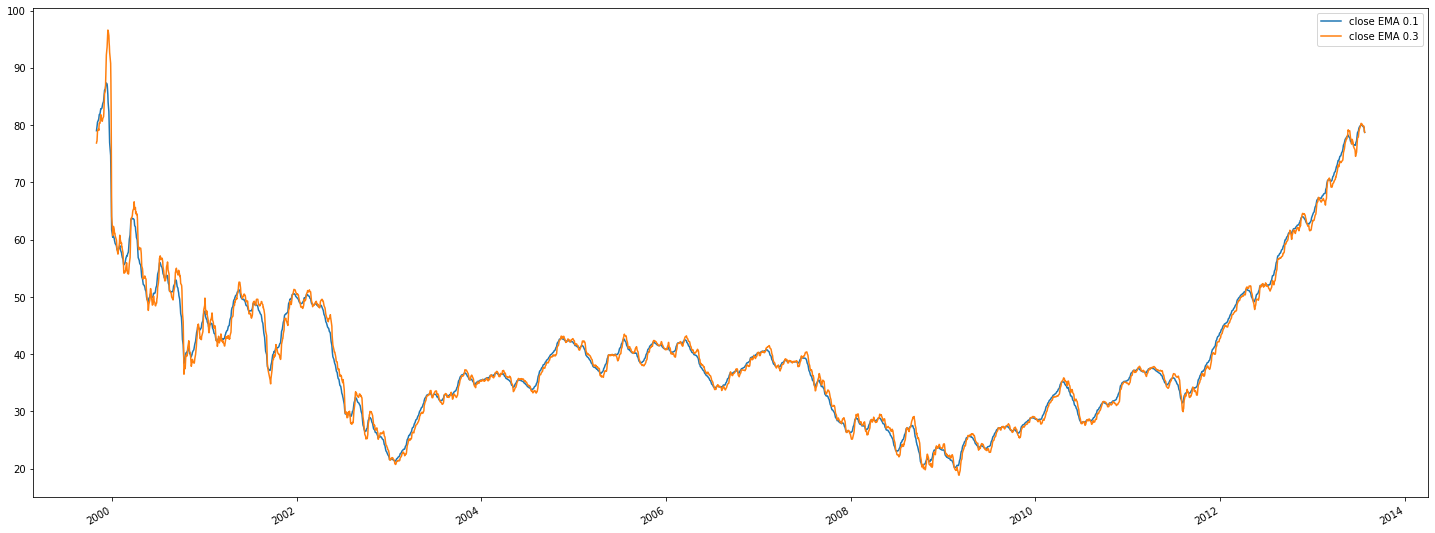

In [129]:
# train_df['close'].plot(figsize=(25, 10))
close_ema_01.plot(figsize=(25, 10))
close_ema_03.plot(figsize=(25, 10))
plt.legend();

Now we will plot the Autocorrelation function ([ACF](https://en.wikipedia.org/wiki/Autocorrelation)]. The Autocorrelation is the correlation of a signal with a delayed copy of itself. The ACF can reveal which lags have significant correlations.

See [this](https://statisticsbyjim.com/time-series/autocorrelation-partial-autocorrelation/) for autocorrelation VS partial autocorrelation

In [159]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

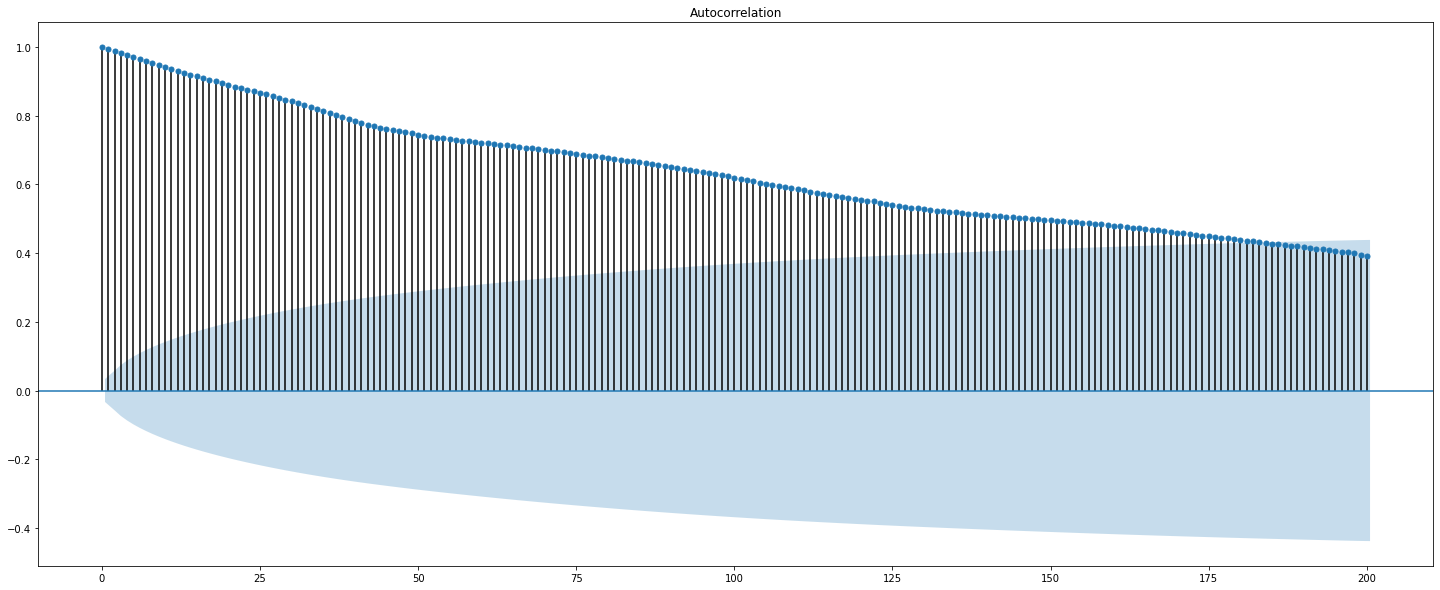

In [158]:
_, ax = plt.subplots(1, 1, figsize=(25, 10))
plot_acf(train_df['close'], lags=200, ax=ax);

From this Autocorrelation plot, we can determine which lags have significant correlations. The lags above the shaded region are statistically significant, the default $\alpha$ value for significance is 0.05. We may be able to suggest that there are trends in the tiem series, since the autocorrelation lags taper off slowly as they increase in value.

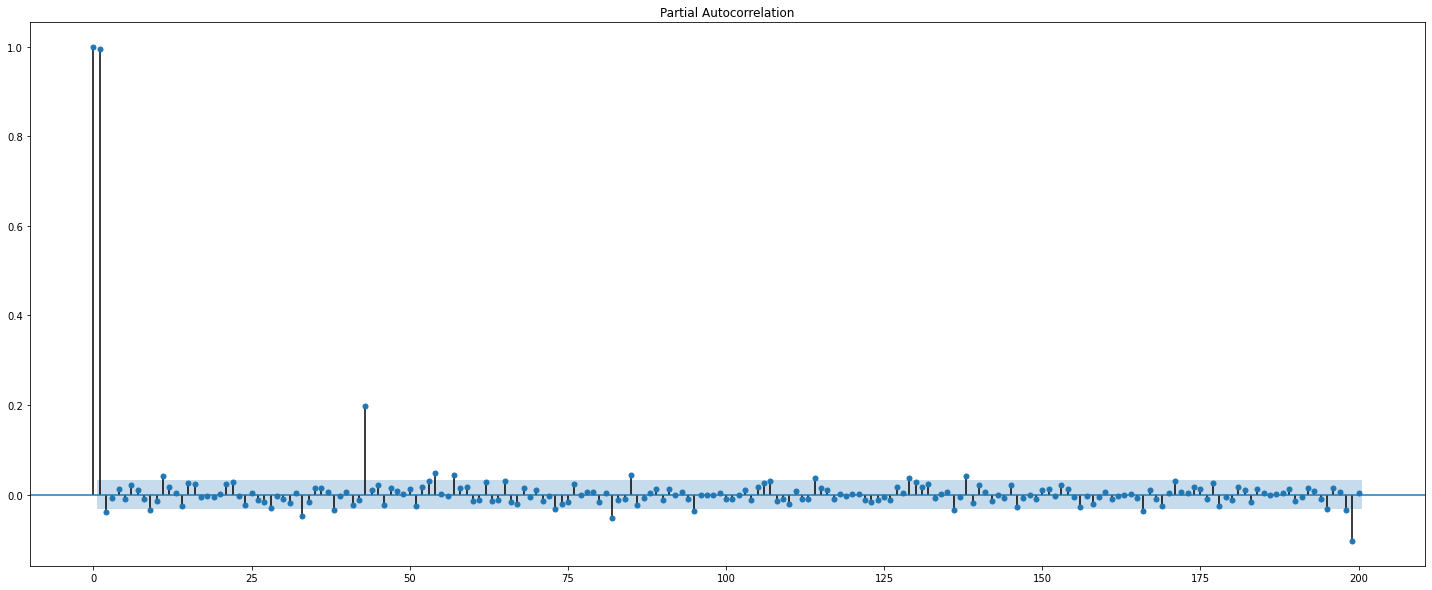

In [165]:
_, ax = plt.subplots(1, 1, figsize=(25, 10))
plot_pacf(train_df['close'], lags=200, ax=ax);

## **Perform Time Series Clustering**

First we will need to identify where the major prices increases and decrease occur.

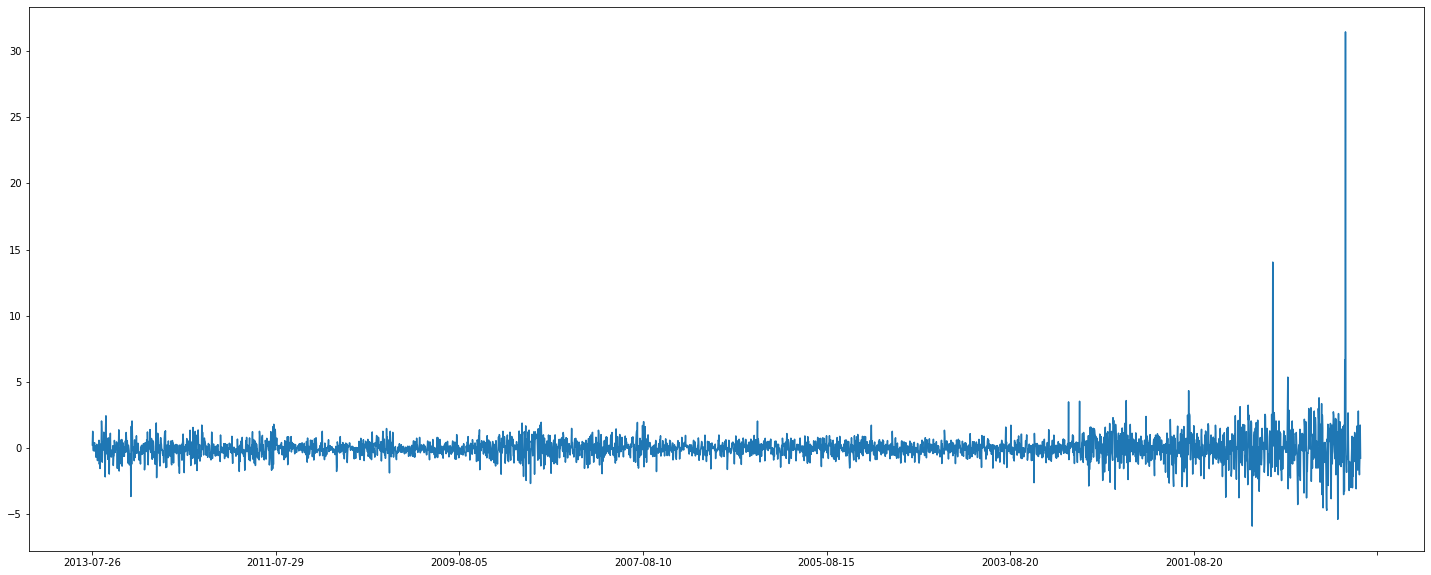

In [230]:
close_diff = train_df['close'].diff()
close_diff.names = 'close diff'
close_diff.plot(figsize=(25, 10));

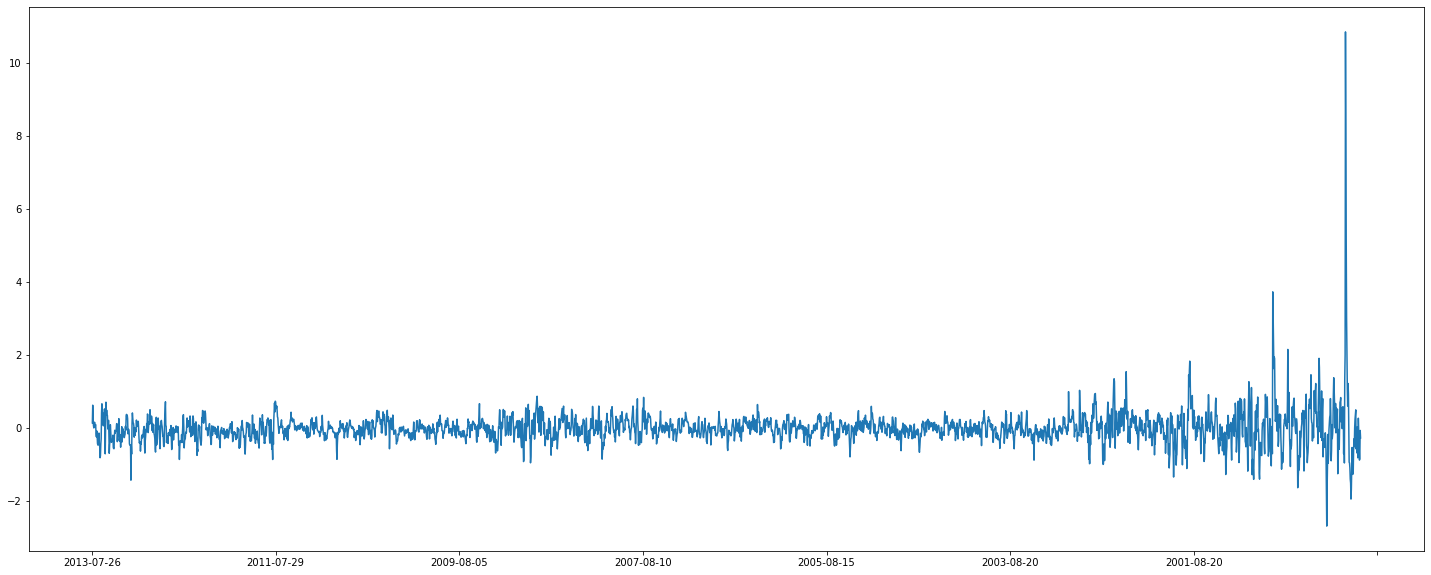

In [320]:
close_ema_03.diff().plot(figsize=(25, 10))

In [328]:
price_increase_locs = np.where(close_diff > 1)[0]
price_decrease_locs = np.where(close_diff < -1)[0]

Now let's get each chop price increase into it's own Time Series of $n$ values. Then we can try to cluster these Time Series and see if there are any consistencies in the data leading up to the price increase. Note that some of the price increases happen on near simultaneous days, especially if there is a large run up. We will need to figure out how to account for this. We will also cluster the Time Series Leading up to price decreases to see if there are any major differences.

In [340]:
n = 25 # number of value per trime series
price_increase_locs = price_increase_locs[price_increase_locs > n]
price_decrease_locs = price_decrease_locs[price_decrease_locs > n]

# get chopped Time Series for price increases
ts_up_list = []
for loc in price_increase_locs:
    ts_vals = train_df['close'].to_numpy()[loc-25:loc+1]
    ts_up_list.append(ts_vals)

# get chopped Time Series for price decreases
ts_down_list = []
for loc in price_decrease_locs:
    ts_vals = train_df['close'].to_numpy()[loc-25:loc+1]
    ts_down_list.append(ts_vals)

In [341]:
ts_up_array = np.array(ts_up_list)
ts_down_array = np.array(ts_down_list)

Now let's cluster the chopped Time Series. We will use [tslearn](https://tslearn.readthedocs.io/en/stable/index.html) to perform K-means clustering on the Time Series. We will also Standardize the Time Series to have 0 mean and a Standard Deviation of 1. We will choose not to detrend or de seasonalize the chopped Time Series, since we want the clusters to capture this information.

In [ ]:
!pip install tslearn

In [342]:
from tslearn.clustering import TimeSeriesKMeans
from tslearn.preprocessing import TimeSeriesScalerMeanVariance

ts_kmeans_up = TimeSeriesKMeans(n_clusters=8, metric="softdtw",
                                max_iter=10, random_state=42)
ts_kmeans_down = TimeSeriesKMeans(n_clusters=8, metric="softdtw",
                                max_iter=10, random_state=42)

ts_up_array_transformed = TimeSeriesScalerMeanVariance(mu=0., 
                                                       std=1.).fit_transform(ts_up_array) \
                                                              .squeeze()
ts_down_array_transformed = TimeSeriesScalerMeanVariance(mu=0., 
                                                       std=1.).fit_transform(ts_down_array) \
                                                              .squeeze()                                                              

In [343]:
ts_up_cluster_locs = ts_kmeans_up.fit_predict(ts_up_array_transformed)

In [344]:
ts_down_cluster_locs = ts_kmeans_down.fit_predict(ts_down_array_transformed)

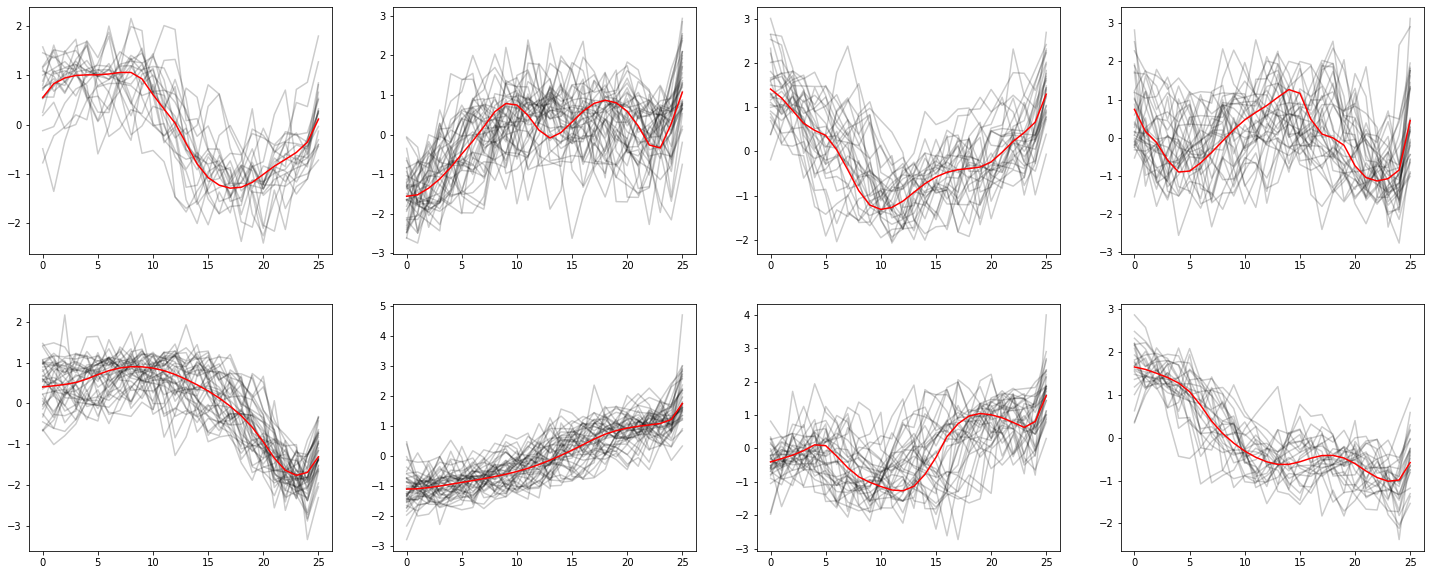

In [345]:
# display price increase clusters
fig = plt.figure(figsize=(25, 10))
for i in range(8):
    plt.subplot(2, 4, 1 + i)
    for ts_vals in ts_up_array_transformed[ts_up_cluster_locs == i]:
        plt.plot(ts_vals.ravel(), 'k-', alpha=.2)

    plt.plot(ts_kmeans_up.cluster_centers_[i].ravel(), 'r-')

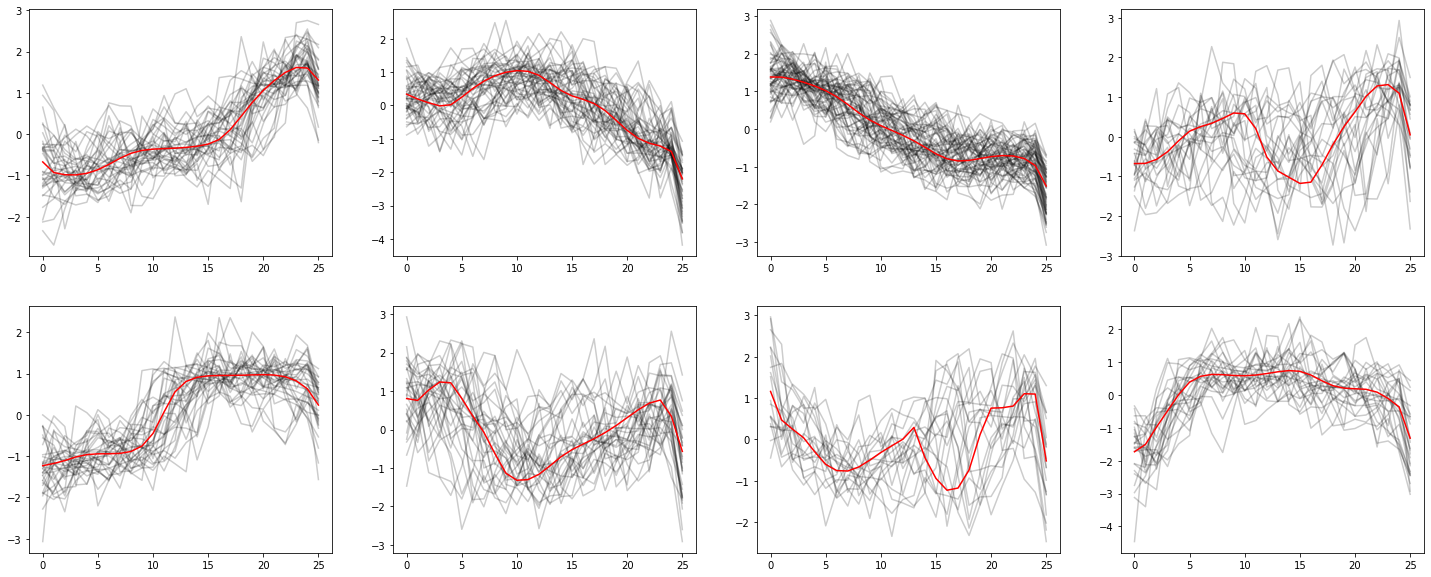

In [346]:
# display price decrease clusters
fig = plt.figure(figsize=(25, 10))
for i in range(8):
    plt.subplot(2, 4, 1 + i)
    for ts_vals in ts_down_array_transformed[ts_down_cluster_locs == i]:
        plt.plot(ts_vals.ravel(), 'k-', alpha=.2)

    plt.plot(ts_kmeans_down.cluster_centers_[i].ravel(), 'r-')

There doesn't seem to be anything special about the clusters obtained from this analysis of daily data. It's possible that more meaningful clusters can be found when observing the data through a different time scale such as an hourly interval or 15minute interval.

## **Perform Fourier Analysis**

## **Perform Wavelet Analysis**